# NOTE!
Since we don't have any rights to publish code or datasets provided by our professors we removed it. If you don't run this notebook, you can see all results. If you are participating in this course a

# Two body scattering

We discuss the two body scattering in a OBE potential, as it was firstly introduced in the [last exercise](https://github.com/dschuechter/physics760_schuechter_krause/tree/master/Exercise06). Our goal is the dermination of the scattering matrix $T_l$ in partial wave decomposition and finally the differential cross section. We used the following parameters: $\Lambda=800$ MeV, $C_0=0.02470795$ $A=−0.1544435$ $m_B=138$ MeV.

## Theory
We start from the Lippmann-Schwinger equation
$$
T_{l}\left(p, p^{\prime}\right)=V_{l}\left(p, p^{\prime}\right)+\int_{0}^{\infty} d p^{\prime \prime} \frac{f\left(p^{\prime \prime}\right)-f(q)}{q^{2}-p^{\prime \prime 2}}+f(q) \int_{0}^{\infty} d p^{\prime \prime} \frac{1}{q^{2}-p^{\prime \prime 2}}-i \pi \frac{f(q)}{2 q},
$$
where $q=\sqrt{2\mu E}$ the on-shell momentum, $f(p^{\prime\prime})=2\mu p^{2}V(p,p^{\prime\prime}t(p^{\prime\prime},p^{\prime}))$ and $\mu= 938.92 $ MeV the reduced mass,
which we now want to rewrite conveniently:

*1. For the discretization of this integral equation, we can again use the grid points $p_i$
$i = 0, . . . , N−1$ and corresponding integration weights $\omega_i$
. This defines a set of unknowns
$t_l(p_i, p_j )$ which does not include the on-shell and half-on-shell t-matrix elements $t_l(q, p_j )$,
$t_l(p_i, q)$, and $t_l(q, q)$. It is therefore useful to define $p_N = q$ and $t_l(p_i
, p_j )$ for $i, j = 0, . . . , N.$ Using these grid points, show that the Lippmann-Schwinger equation can be
written in the form $$V_{ij}=A_{ik}t_{kj},$$ where $O_{ij}=O(p_i,p_j)$ and $$A_{ik}=\begin{cases}\delta_{ik}-\frac{2 \mu V_{i k} p_{k}^{2}}{q^{2}-p_{k}^{2}} \omega_{k} & \text{for } k\neq N \\ \delta_{iN}+\sum_{m=0}^{N-1} \frac{2 \mu V_{i N} q^{2}}{q^{2}-p_{m}^{2}} \omega_{m}-\mu q V_{i N} \ln \left(\frac{p_{\max }+q}{p_{\max }-q}\right)+i \pi \mu q V_{i N} &\text{for } k=N \end{cases}$$*
First we note that $$\int_{0}^{\infty=p_{max}} d p^{\prime \prime} \frac{1}{q^{2}-p^{\prime \prime 2}}=\frac{1}{2q}\log\left(\frac{p_{max}+q}{p_{max}-q}\right).$$
Furthermore we write $$A_{ik}t_{kj}=\sum_{k=0}^{N-1}A_{ik}t_{kj}+A_{iN}t_{Nj}=\left(\sum_{k=0}^{N-1}\delta_{ik}-\frac{2 \mu V_{i k} p_{k}^{2}}{q^{2}-p_{k}^{2}} \omega_{k}\right)t_{kj}+\left(\delta_{iN}+\sum_{m=0}^{N-1} \frac{2 \mu V_{i N} q^{2}}{q^{2}-p_{m}^{2}} \omega_{m}-\mu q V_{i N} \ln \left(\frac{p_{\max }+q}{p_{\max }-q}\right)+i \pi \mu q V_{i N}\right)t_{Nj}=t_{ij}-\sum_{k=m=0}^{N-1}\frac{f(p'')-f(q)}{q^2-p''^2}\omega_k-\int_{0}^{\infty=p_{max}} d p^{\prime \prime} \frac{1}{q^{2}-p^{\prime \prime 2}}+i\pi f(q)=V_{ij}$$

The S-matrix, which is related to the T-matrix in the following way $$S(q)=1-2\pi i \mu q T(q,q),$$ fulfills the important property $|S(q)|=1$. This allows us to cross check the results of our code. It also allows to define a real phase $\delta(q)$ which is defined via $$S(q)=e^{i2\delta(q)}.$$


## Aim of the code


*2. Implement the discretized form of the Lippmann-Schwinger equation to obtain the onshell matrix element $t_{NN}$.*

As seen above, we now have a matrix equation to solve $$V_{ij}=A_{ik}t_{kj}$$ which can easily be done by using the standard library ``numpy.linalg``. We now have to implement the matrices and obtain the grid points and weights from an external ``.dat`` file that was provided for the parameters we used.

The code can be found below.

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
from scipy.special import sph_harm
from scipy.interpolate import interp1d
from functions import * #Import the functions given in the lecture  
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('wf-obe-lam=800.00.dat', delimiter=';')#import momenta


Lambda = 800
C0 = 2.470795e-02
hbarc = 197.327
E = -2.225/hbarc
mu =  938.92/hbarc
A = -0.1544435 
m_B = 138
p = np.array(data[:,0])
p = np.append(p,0) #append 0 to overwrite later
p_max = p[-2] #this is the last element in the imported array
w = np.array(data[:,1])
w = np.append(w,0) 
pot=OBEpot(nx=20,mpi=m_B,C0=C0,A=A,cutoff=Lambda)#generate potential from a. noggas class


In [3]:
#implement matrix elements, no wizardry here, only definitions
def delta(i,j):
    if i==j:
        return 1
    else:
        return 0
def V_matrix(i,j,l):
    return pot.v(p[i],p[j],l)
    
def A_matrix(i,k,N,p_max,q,l):
    if k != N:
        return delta(i,k)-2*mu*V_matrix(i,k,l)*p[k]**2*w[k]/(q**2-p[k]**2)
    else:
        return delta(i,k)+np.sum(2*mu*V_matrix(i,N,l)*q**2*w[:-1]/(q**2-p[:-1]**2))-mu*q*V_matrix(i,N,l)*np.log((p_max+q)/(p_max-q))+1j*np.pi*mu*q*V_matrix(i,N,l)
    

#generate NxN objects to use in the linear solver
def gen_matrices(N,q,l):
    p[-1] = q
    A_mat = []
    V_mat = []
    for i in range(N):
        A_mat.append([])
        V_mat.append([])
        for j in range(N):
            A_mat[i].append(A_matrix(i,j,N-1,p_max,q,l))
            V_mat[i].append(V_matrix(i,j,l))
    return A_mat, V_mat

def t_matrix(q,l):
    A_mat, V_mat = gen_matrices(len(p),q,l)
    return np.linalg.solve(A_mat, V_mat)#solve the matrix equation, main feature of the code ...

def S_matrix(q,l):
    return 1-2*1j*np.pi*mu*q*t_matrix(q,l)[-1][-1]#determine s-matrix

*4. Check that your code reproduces $|S(q)|=1$ and plot the phase shift such that is continous and approaches $0$ at large $E$*

In [4]:
t_mat = t_matrix(1,0)
np.abs(S_matrix(1,0))

1.0000000000000007

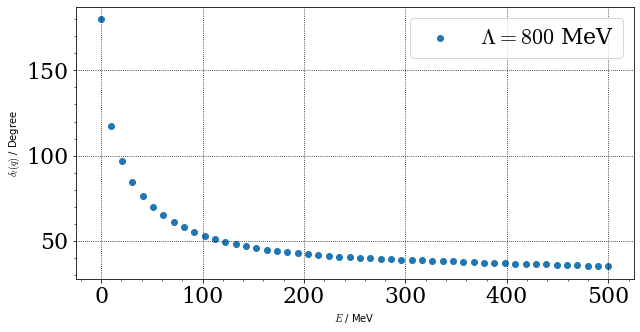

In [5]:
#plot the phase shift
beauty_plot()
E_list = np.linspace(0,500,50)/hbarc
q_list = np.sqrt(np.array(E_list)*mu*2)
phase_shift = []
counter=0
for q in q_list:
    counter+=1
    phase_shift.append(np.real(-0.5*1j*np.log(S_matrix(q,0)))*180/np.pi)
    if phase_shift[-1]<0 or q<0.5:
        phase_shift[-1]=phase_shift[-1]+180 # changing delta by 180 degrees does not change S

plt.scatter(E_list*hbarc,(np.array(phase_shift)), label = "$\Lambda=%d$ MeV"%(Lambda))
plt.xlabel("$E$ / MeV")
plt.ylabel("$\delta_l(q)$ / Degree")
plt.legend()
plt.show()

*5. Express the differential cross section as a sum of partial waves. Plot the differential cross section
depending on $\theta$ for $E = 10 $ MeV. Compare results for summing up to $l = 0, 1, 2, 3, 4, 5, 6$.*
$$\frac{d\sigma}{d\Omega}=(2\pi)^4\mu^2|T|^2=\dots=\pi^2\mu^2\left|\sum_l(2l+1)t_l(q,q)P_l(x)\right|^2$$
with the Legendre Polynomials $P_l(x)=P_l(\cos\theta)$ and $T=\sum_{l,m}Y_{lm}^*(\hat{q}_f)Y_{lm}(\hat{q}_i)t_l(q_f,q_i)=\sum_l t_l(q_f,q_i)\frac{2l+1}{4\pi}P_l(x)$.

In [6]:
#define cross section
def cross_sec(mu,q,x,lmax):
    Pl=legendre(lmax)
    l_sum=np.sum([(2*l+1)*t_matrix(q,l)[-1][-1]*Pl(x) for l in range(0,lmax+1)])
    return np.pi**2*mu**2*np.abs(l_sum)**2

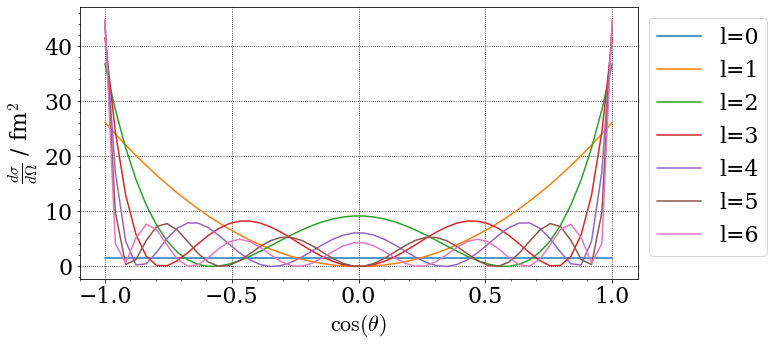

In [7]:
#!CAUTION! this cell does take REALLY long to produce the plot, for quicker results lower the amount of points for x
#plot cross section
x=np.linspace(-1,1,50)
l_list=[i for i in range(0,7)]
beauty_plot()
for lmax in l_list:
    y=[cross_sec(mu,np.sqrt(2*10/hbarc*mu),x,lmax) for x in x]
    plt.plot(x,y,label="l=%d"%(lmax))
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("$\cos(\\theta)$")
plt.ylabel("$\\frac{d\sigma}{d\Omega}$ / fm$^{2}$")
plt.show()
